In [130]:
import os
import os.path as osp

import struct

import easydict

import numpy as np

import utils

In [131]:
kitti_obj3d_det_cls_names = [
    "DontCare",
    "Car",
    "Cyclist",
    "Misc",
    "Pedestrian",
    "Person_sitting",
    "Tram",
    "Truck",
    "Van"
]

# class name and label index
cls2ldx = {v: i for (i, v) in enumerate(kitti_obj3d_det_cls_names)}
ldx2cls = {i: v for (v, i) in cls2ldx.items()}
print(cls2ldx)
print(ldx2cls)

label_field_name_list = [
    "object_type",
    "truncation",
    "occlusion",
    "alpha",
    "left", "top", "right", "bottom",
    "height", "width", "length",
    "x", "y", "z",
    "rotation_y"
]

{'DontCare': 0, 'Car': 1, 'Cyclist': 2, 'Misc': 3, 'Pedestrian': 4, 'Person_sitting': 5, 'Tram': 6, 'Truck': 7, 'Van': 8}
{0: 'DontCare', 1: 'Car', 2: 'Cyclist', 3: 'Misc', 4: 'Pedestrian', 5: 'Person_sitting', 6: 'Tram', 7: 'Truck', 8: 'Van'}


In [132]:
# only for train set
def convert_kitti_train_bin(kitti_obj3d_root: str, sample_index: int) -> np.ndarray:
    '''
    - kitti_obj3d_root: path to dataset dir containing training and testing dir
    - sample_index: frame data index
    '''
    assert osp.exists(kitti_obj3d_root), "dataset root not exist"
    assert sample_index >= 0 and sample_index <= 7480,\
        "index out of train samples in kitti object 3d dataset"

    sample_index = f"{sample_index:06d}" # pad with 0

    # step 1 - read lidar points
    bin_path = osp.join(
        kitti_obj3d_root, "training", "velodyne", f"{sample_index}.bin"
    )
    bin_size = osp.getsize(bin_path)
    assert bin_size % 16 == 0, "invalid binary structure for kitti bin"

    lidar = []
    with open(bin_path, "rb") as f:
        while True:
            byte_data = f.read(4)
            if len(byte_data) < 4:
                break
            lidar.append(struct.unpack('f', byte_data))
    
    lidar = np.array(lidar).reshape((-1, 4))

    points = lidar[:, :3] # xyz coordinates
    reflec = lidar[:,  3] # reflective intensity
    ptscls = np.zeros(len(points)) # points classes




    # step 2 - read bounding box and calibration info
    def is_float(item):
        try:
            item = float(item)
        except Exception as e:
            return False
        return True

    label_list = None
    with open(
        osp.join(
            kitti_obj3d_root,
            "training",
            "label_2",
            f"{sample_index}.txt"),
            "r"
    ) as f:
        item_list = [
            tuple(
                [float(item) if is_float(item) else item for item in line.strip().split()]
            ) for line in f.readlines()
        ]
    
    label_list = [
        easydict.EasyDict(
            {field:value for (field, value) in zip(label_field_name_list, item)}
        ) for item in item_list
    ]

    calib = None
    with open(
        osp.join(
            kitti_obj3d_root,
            "training",
            "calib",
            f"{sample_index}.txt",
        ), "r"
    ) as f:
        item_list = [
            line.strip().split() for line in f.readlines() if len(line.strip()) > 0
        ]
    calib = easydict.EasyDict(
        {item[0][:-1]:[float(x) for x in item[1:]] for item in item_list}
    )




    # step 3 - label mask
    for label in label_list:
        if label.object_type == "DontCare":
            continue
        
        R_cam = utils.R_mat(label.rotation_y, [0, 1, 0])
        T_cam = utils.T_vec([label.x, label.y, label.z])
        
        # transform from camera coordinate to velodyn coordinate
        vly2cam = np.array(calib.Tr_velo_to_cam).reshape((3, 4))
        R_vly2cam = vly2cam[:3, :3]
        T_vly2cam = vly2cam[: ,  3].reshape((-1, 1))

        T_vly = R_vly2cam.T @ (T_cam - T_vly2cam)
        R_vly = R_vly2cam.T @ R_cam @ R_vly2cam

        bbox_expand_ratio = 5e-2
        w, l, h, b = label.width/2 + label.width * bbox_expand_ratio,\
                     label.length/2 + label.length * bbox_expand_ratio,\
                     label.height + label.height * bbox_expand_ratio,\
                     1e-2

        lb_vly = np.array([-w, -l, +b]).reshape((-1, 1)) # left bottom
        rt_vly = np.array([+w, +l, +h]).reshape((-1, 1)) # right top

        points_msk = R_vly.T @ (points.T - T_vly)
        mask = np.all((points_msk.T >= lb_vly.T) & (points_msk.T <= rt_vly.T), axis=1)

        ptscls[mask] = cls2ldx[label.object_type]



    # step 4 - spherical projection
    # only project the front 90 degree view range

    IMG_W = 512
    IMG_H = 64

    mask = points[:, 1] / np.linalg.norm(points[:, :2], axis=1)
    # angle between -45 and +45
    mask = (points[:, 0] > 0) & (mask > np.sin(-np.pi / 4)) & (mask < np.sin(+np.pi / 4))

    front_indics = np.array(list(range(len(points))))[mask]

    x = np.arcsin(points[mask, 1] / np.linalg.norm(points[mask, :2], axis=1))
    y = np.arcsin(points[mask, 2] / np.linalg.norm(points[  mask  ], axis=1))

    field_x_range, res_x = np.pi / 2               , IMG_W
    filed_y_range, res_y = y.max() - y.min() + 1e-2, IMG_H

    delta_x = field_x_range / res_x
    delta_y = filed_y_range / res_y

    x = (x // delta_x).astype(np.int32)
    y = (y // delta_y).astype(np.int32)

    x = x - x.min()
    y = y - y.min()

    gdth = np.zeros((IMG_H, IMG_W))
    fmap = np.zeros((IMG_H, IMG_W, 5))
    rmap = [[[] for _ in range(IMG_W)] for _ in range(IMG_H)]

    # fill the feature map `fmap` [x, y, z, r, i]
    # as there might be multiple points projected into one grid
    # I choose not to use np.add.at to parallel projection
    for i in range(len(front_indics)):
        rmap[y[i]][x[i]].append(front_indics[i])

        dist = np.linalg.norm(points[front_indics[i]])
        if  fmap[y[i], x[i]][3] != 0 and dist < fmap[y[i], x[i]][3]:
            fmap[y[i], x[i]] = np.array([*points[front_indics[i]], dist, reflec[front_indics[i]]])
            gdth[y[i], x[i]] = ptscls[front_indics[i]]
        else:
            fmap[y[i], x[i]] = np.array([*points[front_indics[i]], dist, reflec[front_indics[i]]])
            gdth[y[i], x[i]] = ptscls[front_indics[i]]
    
    return fmap, gdth, rmap

```python
import sys

print(fmap.shape, sys.getsizeof(fmap) / 2**10)
print(gdth.shape, sys.getsizeof(gdth) / 2**10)
```

output:
```txt
(64, 512, 5) 1280.140625
(64, 512) 256.125
```

One sample = 1.5 MB

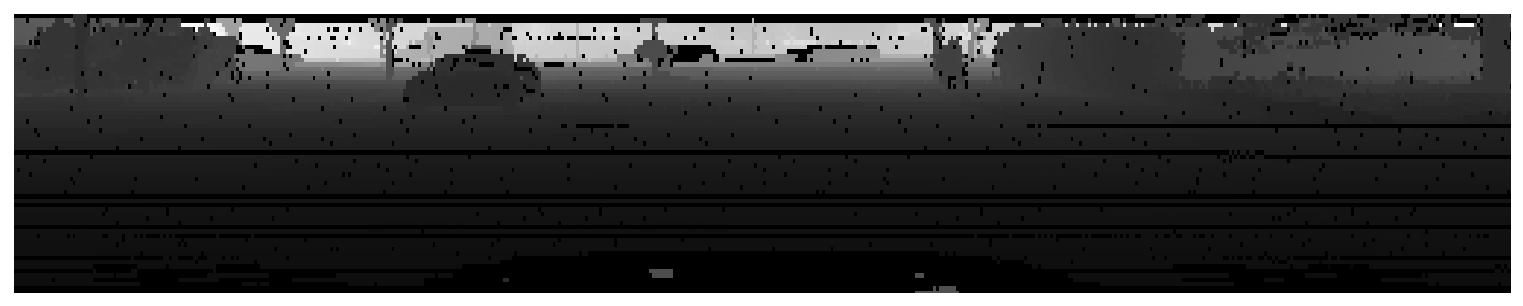

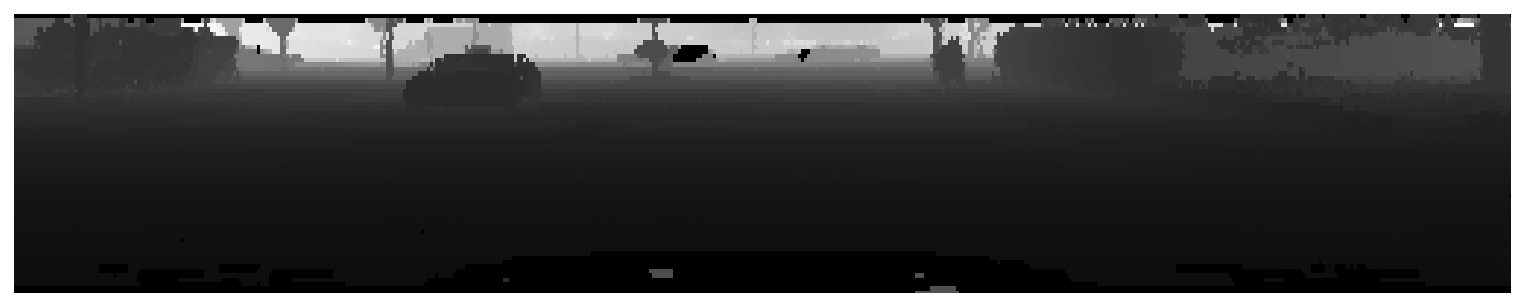

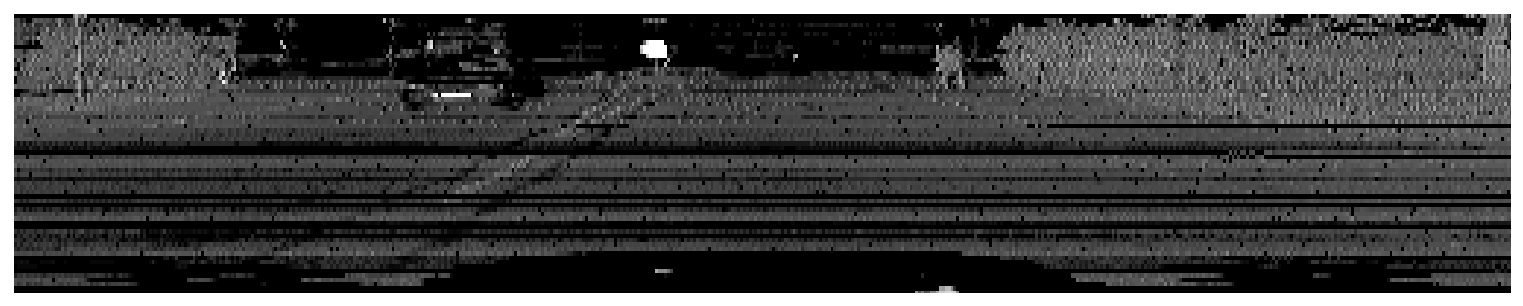

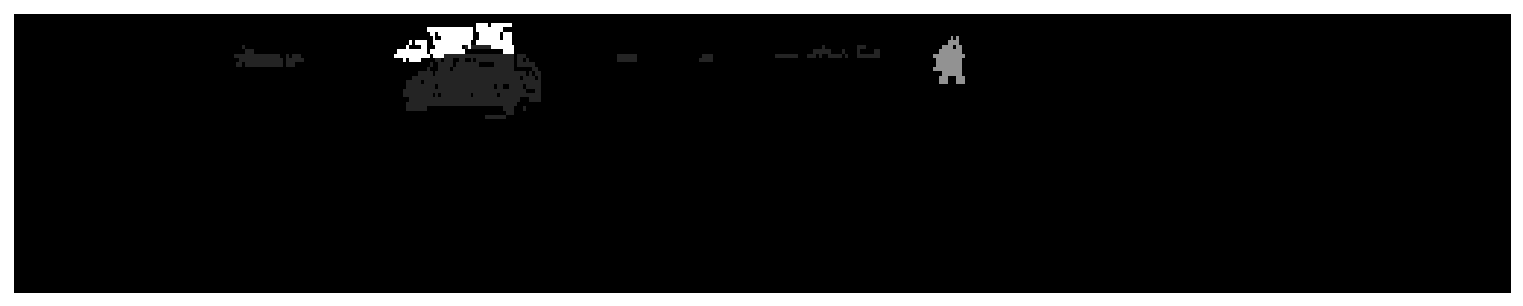

In [133]:
import matplotlib
import matplotlib.pyplot as plt

import random

def fill_blank(img: np.ndarray, trh: float):
    IMG_H, IMG_W = img.shape

    img_filled = np.copy(img)

    dirs = [
        [ 0,  1],
        [ 0, -1],
        [ 1,  0],
        [-1,  0],
        [ 1,  1],
        [ 1, -1],
        [-1,  1],
        [-1, -1]
    ]

    def in_bound(i: int, j: int) -> bool:
        if i < 0 or i >= IMG_H:
            return False
        if j < 0 or j >= IMG_W:
            return False
        return True

    for i in range(IMG_H):
        for j in range(IMG_W):
            if img[i][j] >= trh:
                continue
            sum = 0.0
            cnt = 0.0
            for d in dirs:
                u = i + d[0]
                v = j + d[1]
                if in_bound(u, v) and img[u][v] > trh:
                    sum += img[u][v]
                    cnt += 1
            if cnt >= 4:
                img_filled[i][j] = sum / cnt
    
    return img_filled


def show_spherical_proj(img: np.ndarray):
    plt.figure(figsize=(12, 6), dpi=128, tight_layout=True)
    plt.axis([512, 0, 0, 64])
    plt.axis("off")
    plt.imshow(img, cmap="gray", aspect=1.5, interpolation='nearest')



fmap, gdth, rmap = convert_kitti_train_bin("data", random.randint(0, 7480 + 1))

depth_img = fmap[:, :, 3]
depth_img = depth_img / depth_img.max()
filld_img = fill_blank(depth_img, 1e-3)
light_img = fmap[:, :, 4]

show_spherical_proj(depth_img)
show_spherical_proj(filld_img)
show_spherical_proj(light_img)
show_spherical_proj(gdth)
